In [16]:
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
import statsmodels.api as sm
import statsmodels.formula.api as smf
%pylab inline

pl.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


##We will use 2 different datasets.
##an interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". for example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
##so let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

In [2]:

nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA")+
                               "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
print nrg.columns


Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


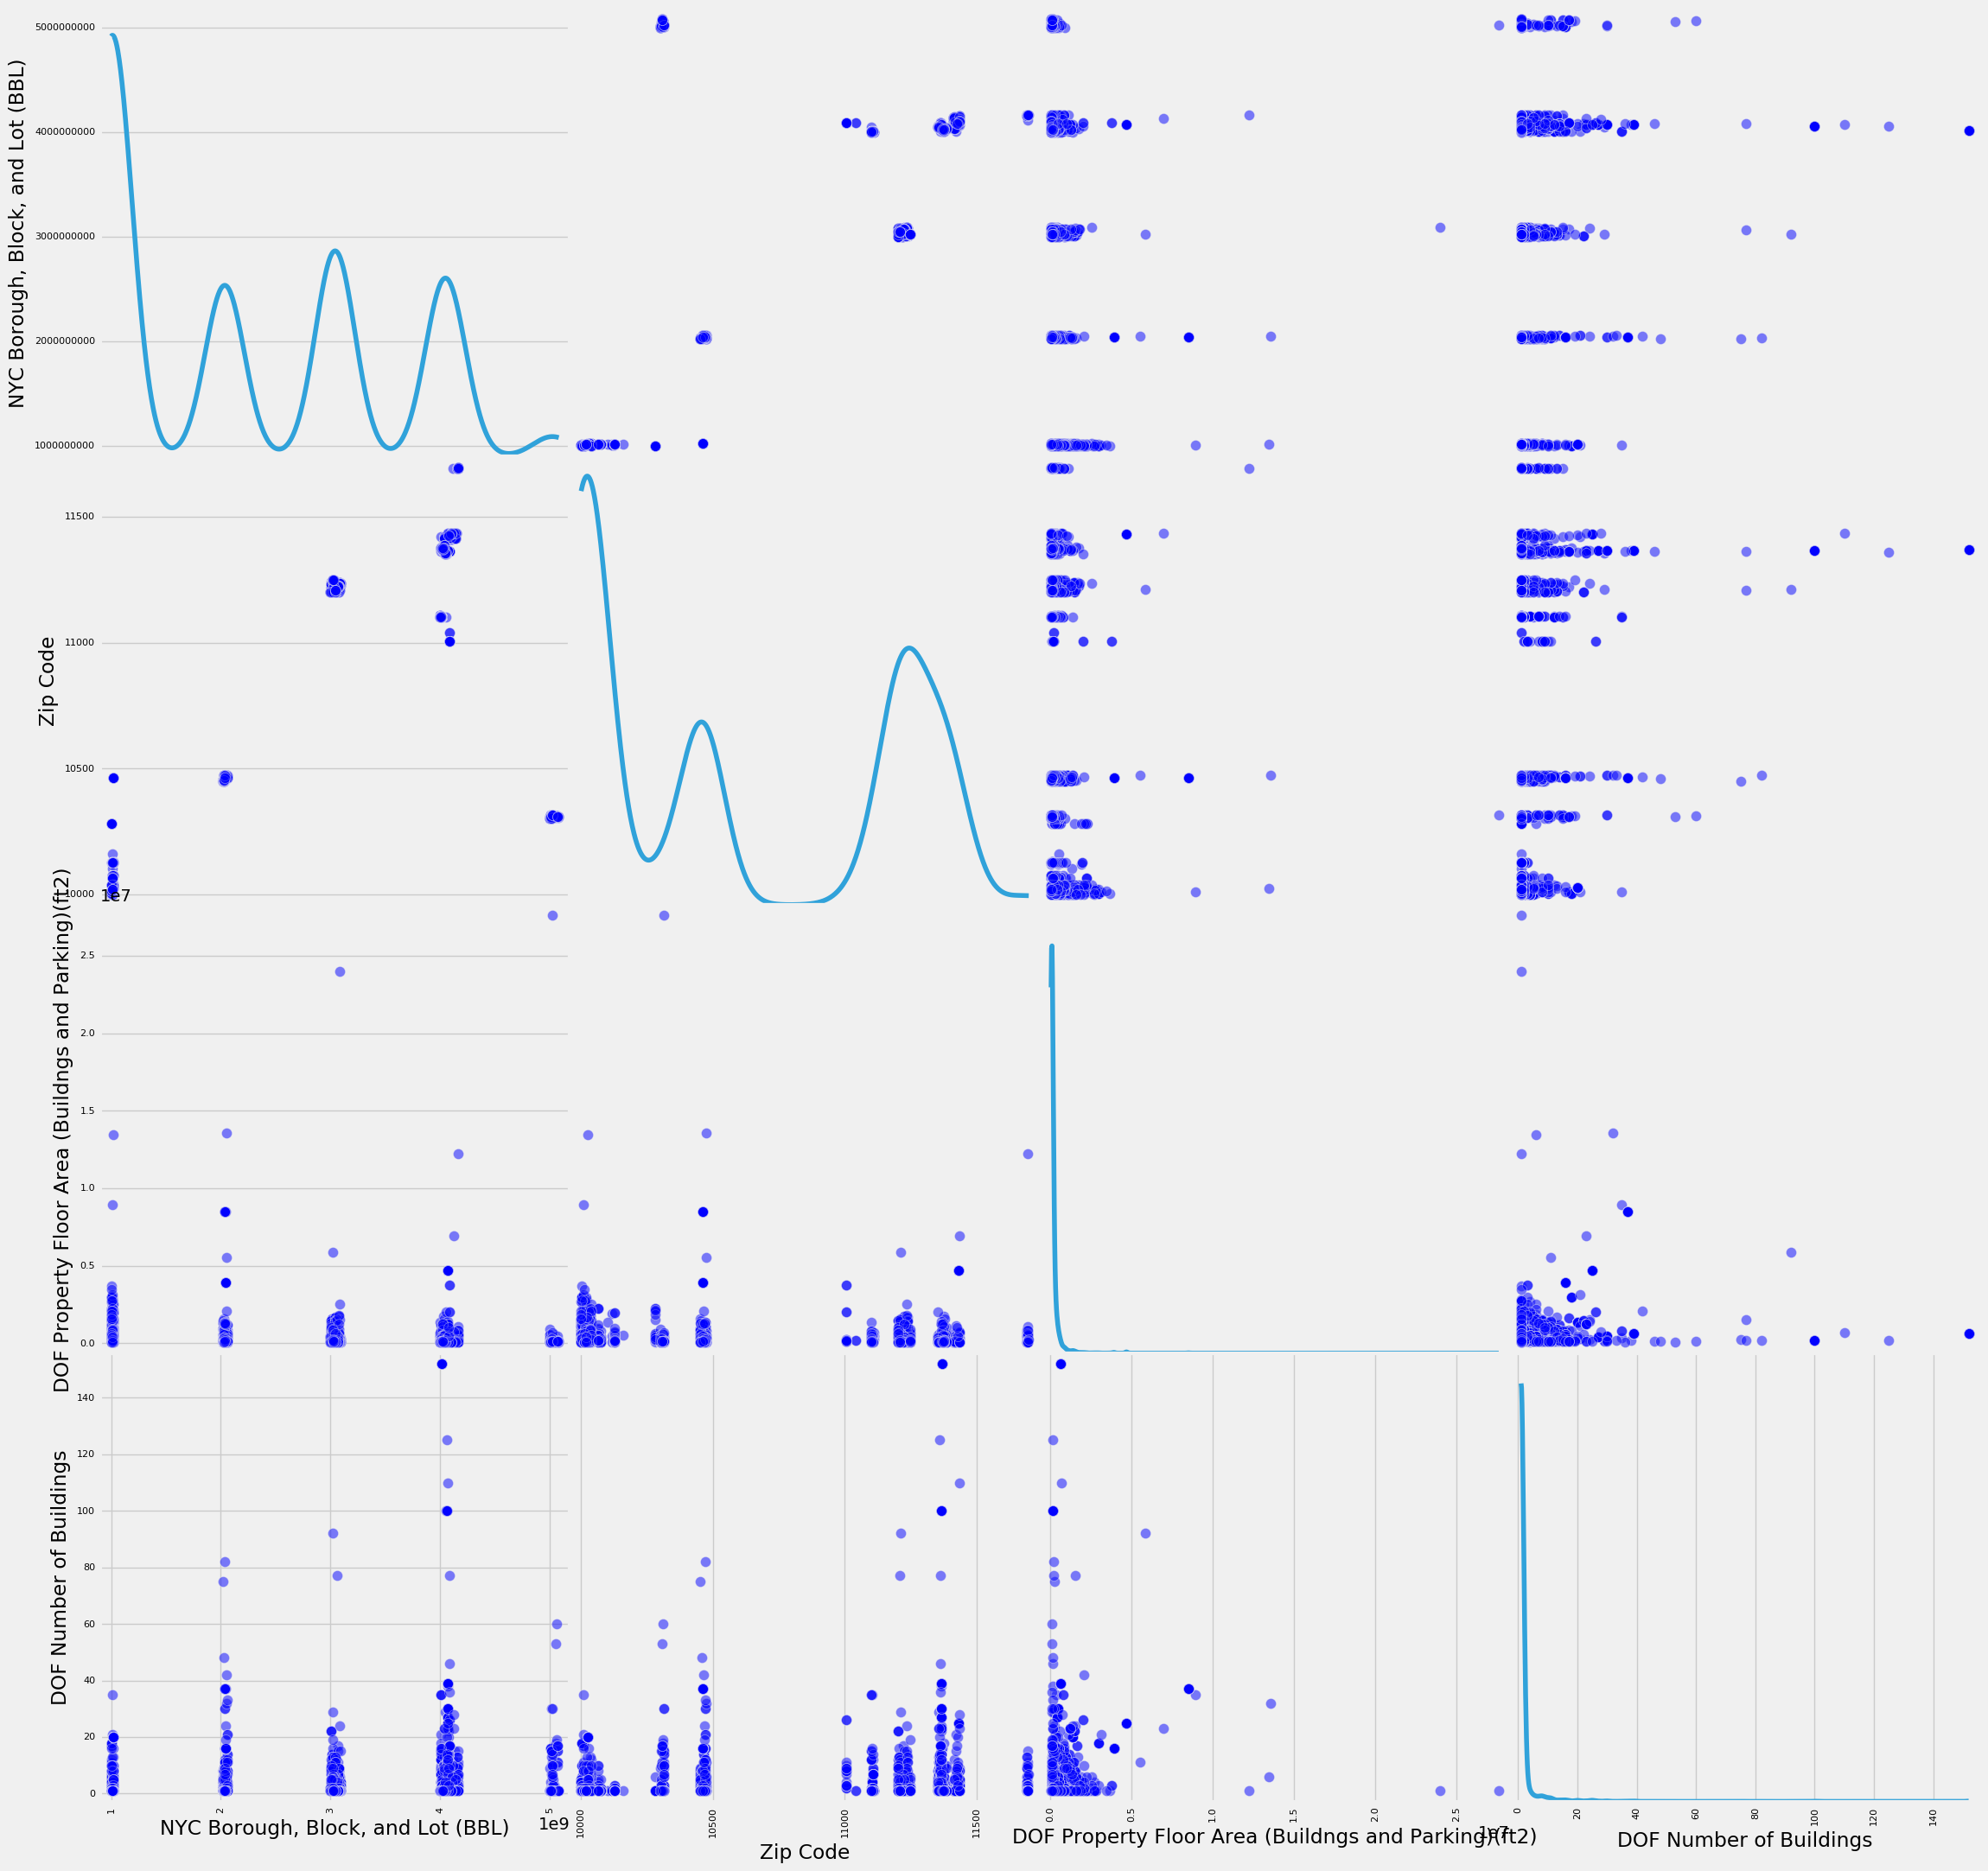

In [5]:
pd.scatter_matrix (nrg, s=300, figsize=(25, 25), diagonal='kde')
pl.show()

#however this datasets does not have the number of units. We can find that in the Pluto dataset.
reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [7]:
bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA")+"/Manhattan/MNMapPLUTO.shp")
print (bsize.columns)

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

in pandas scatter_matrix will plot each column agains each other. that is a great way to begin inspecting your data (though be careful cause it is computationally comsuming for large datasets) 



In [8]:
nrg.rename(columns={"NYC Borough, Block, and Lot (BBL)": "BBL"}, inplace=True)

In [9]:

bblnrgdata = pd.merge(nrg, bsize, on=["BBL"])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:2097: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:1237: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


In [11]:
a = pd.to_numeric(bblnrgdata['Site EUI(kBtu/ft2)'], errors="coerce")
b = pd.to_numeric(bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'],errors="coerce")
bblnrgdata["energy_comsumption"] = a.multiply(b)
bblnrgdata = bblnrgdata[~bblnrgdata.energy_comsumption.isnull()]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:1945: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(key)


In [12]:
bblnrgdata = bblnrgdata[(bblnrgdata.energy_comsumption > 1000)
                        & (bblnrgdata["UnitsRes"] > 10)]

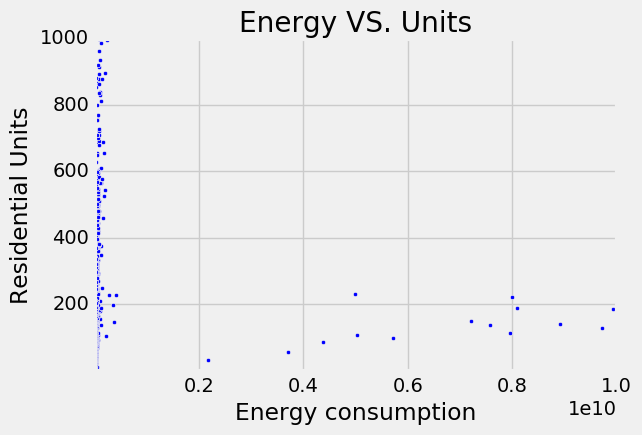

In [14]:
ax = bblnrgdata.plot.scatter(y="UnitsRes", x="energy_comsumption", s=10)
ax.set_ylim(1,1000)
ax.set_xlim(1000,1e10)
ax.set_xlabel("Energy consumption")
ax.set_ylabel("Residential Units")
ax.set_title("Energy VS. Units")
pl.show()

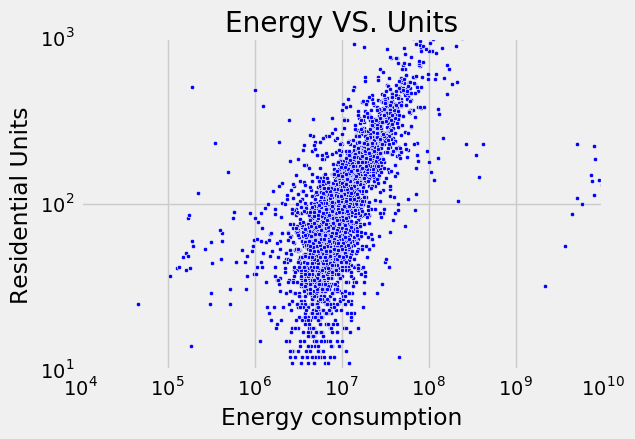

In [15]:

ax = bblnrgdata.plot.scatter(y="UnitsRes", x="energy_comsumption", s=10, loglog=True)
ax.set_ylim(10,1000)
ax.set_xlim(1e4,1e10)
ax.set_xlabel("Energy consumption")
ax.set_ylabel("Residential Units")
ax.set_title("Energy VS. Units")
pl.show()

In [21]:
X = sm.add_constant(np.log10(bblnrgdata.UnitsRes))
model = sm.OLS(np.log10(bblnrgdata.energy_comsumption), X, missing='drop') 
fit_U = model.fit()
Y = fit_U.predict()
y = np.log10(bblnrgdata.energy_comsumption)
sigma = y/2 ## error term
chisq = ((y - Y)**2 / sigma**2).sum()

print ("Chi-Sqaure test result for Units vs. Energy is {}".format(chisq))

Chi-Sqaure test result for Units vs. Energy is 38.1108105813


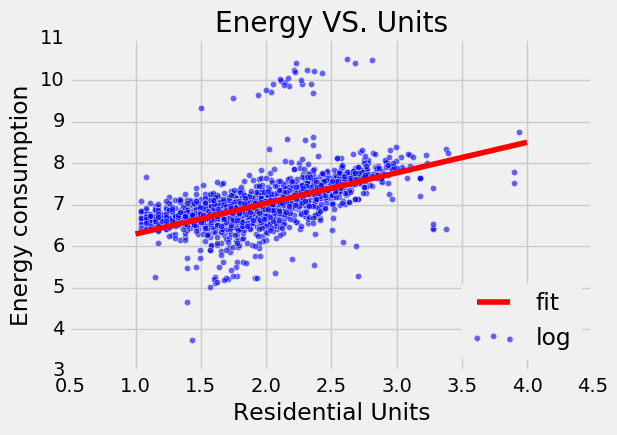

In [50]:

pl.scatter(log10(bblnrgdata.UnitsRes), log10(bblnrgdata.energy_comsumption), alpha=0.6, label="log")
x_line = np.linspace(1,4,1000)
x_fit = sm.add_constant(x_line)
pl.plot(x_line, fit_U.predict(x_fit), 'r-', label="fit")
pl.plot()
pl.ylabel("Energy consumption")
pl.xlabel("Residential Units")
pl.title("Energy VS. Units")
plt.xlim([0.5,4.5])
pl.legend(loc="lower right")
pl.show()

In [27]:
fit_U.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     energy_comsumption   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     1887.
Date:                Sun, 16 Oct 2016   Prob (F-statistic):               0.00
Time:                        13:26:08   Log-Likelihood:                -1522.2
No. Observations:                3461   AIC:                             3048.
Df Residuals:                    3459   BIC:                             3061.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.5525      0.034    163.619      0.000         5.486     5.619
UnitsRes       0.7367      0.017     43.443      0.000         0.703     0.770
==============================================================================
Omnibus:                     2110.786   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            96633.357
Skew:                           2.246   Prob(JB):                         0.00
Kurtosis:                      28.494   Cond. No.                         13.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# fit Energy vs Units.
X = sm.add_constant(np.log10(bblnrgdata.energy_comsumption))
model = sm.OLS(np.log10(bblnrgdata.UnitsRes), X, missing='drop') 
fit_E = model.fit()
Y = fit_E.predict()
y = np.log10(bblnrgdata.UnitsRes)
sigma = y/2 ## error term
chisq = ((y - Y)**2 / sigma**2).sum()

print ("Chi-Sqaure test result for Energy vs. Units is {}".format(chisq))

Chi-Sqaure test result for Energy vs. Units is 420.665629853


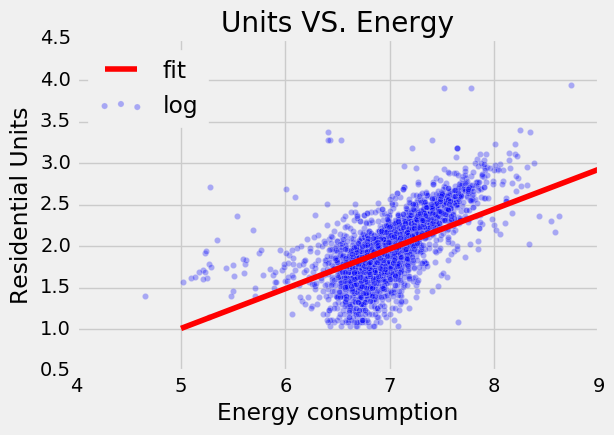

In [49]:

pl.scatter(log10(bblnrgdata.energy_comsumption), log10(bblnrgdata.UnitsRes), alpha=0.3, label="log")
x_line = np.linspace(5,9,1000)
x_fit = sm.add_constant(x_line)
pl.plot(x_line, fit_E.predict(x_fit), 'r-', label="fit")
pl.plot()
pl.ylabel("Residential Units")
pl.xlabel("Energy consumption")
pl.title("Units VS. Energy")
pl.legend(loc="upper left")
plt.xlim(4,9)
pl.show()


In [33]:
fit_E.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               UnitsRes   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     1887.
Date:                Sun, 16 Oct 2016   Prob (F-statistic):               0.00
Time:                        13:28:01   Log-Likelihood:                -777.79
No. Observations:                3461   AIC:                             1560.
Df Residuals:                    3459   BIC:                             1572.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                 -1.3890      0.077    -17.949      0.000        -1.541    -1.237
energy_comsumption     0.4792      0.011     43.443      0.000         0.458     0.501
==============================================================================
Omnibus:                      280.358   Durbin-Watson:                   1.427
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1479.588
Skew:                          -0.173   Prob(JB):                         0.00
Kurtosis:                       6.184   Cond. No.                         108.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Chisquare test shown that unit vs energy is better than energy vs units

In [35]:
new_data = bblnrgdata[["energy_comsumption","UnitsRes"]]
new_data = new_data.applymap(np.log10)

In [36]:
new_data.head(5)

,energy_comsumption,UnitsRes
19,6.950549,1.732394
20,6.811909,1.875061
21,6.860458,2.107210
23,6.919769,1.748188
24,10.415995,2.685742


In [37]:
new_data["UR2"] = new_data.UnitsRes**2

In [40]:
poly_1 = smf.ols(formula = 'energy_comsumption ~ UR2 + UnitsRes', data=new_data).fit()

In [41]:
poly_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     energy_comsumption   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     971.1
Date:                Sun, 16 Oct 2016   Prob (F-statistic):               0.00
Time:                        14:30:07   Log-Likelihood:                -1504.3
No. Observations:                3461   AIC:                             3015.
Df Residuals:                    3458   BIC:                             3033.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.2299      0.118     52.823      0.000         5.999     6.461
UR2            0.1669      0.028      5.995      0.000         0.112     0.222
UnitsRes       0.0519      0.115      0.450      0.653        -0.174     0.278
==============================================================================
Omnibus:                     2111.535   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106260.647
Skew:                           2.217   Prob(JB):                         0.00
Kurtosis:                      29.781   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

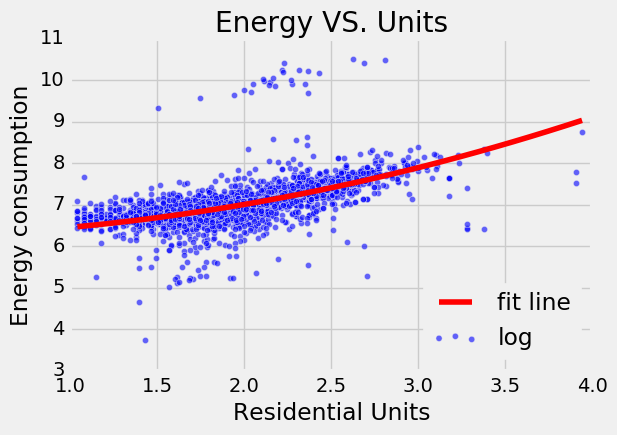

In [47]:
pl.scatter(log10(bblnrgdata.UnitsRes), log10(bblnrgdata.energy_comsumption), alpha=0.6, label="log")
new_df = pd.DataFrame()
new_df['UnitsRes'] = np.arange(log10(bblnrgdata.UnitsRes).min(), log10(bblnrgdata.UnitsRes).max(), 0.1)
new_df['UR2'] = new_df['UnitsRes'] * new_df['UnitsRes']
pl.plot(new_df['UnitsRes'], poly_1.predict(new_df), 'r-', label="fit line")
pl.plot()
pl.ylabel("Energy consumption")
pl.xlabel("Residential Units")
pl.title("Energy VS. Units")
plt.xlim([1,4])
pl.legend(loc="lower right")
pl.show()

## model 1 loglikelihood = 1522, model 2 loglikelihood = 1504

In [51]:
LR = -2*((-1522.2) - (-1504.3))
LR

35.80000000000018

In [53]:
smf.ols(formula = 'energy_comsumption ~ UR2 + UnitsRes', data=new_data).fit().compare_lr_test(smf.ols(formula = 'energy_comsumption ~  UnitsRes', 
                                                                                 data=bblnrgdata).fit())

(151899.78500904227, 0.0, 1.0)

In [54]:
errors = np.log10(bblnrgdata.energy_comsumption)/2

In [55]:
def residual(a,b): 
    temp = (np.log10(bblnrgdata.energy_comsumption) - (np.log10(bblnrgdata.UnitsRes)*a+b))**2 
    return (temp/ errors**2).sum()

In [56]:
intercp = np.arange (-100, 100, 1)
slope =  np.arange(-50.0, 50.0, 0.5)

In [57]:
Lsurface = np.zeros((len(slope), len(intercp)))

In [58]:
vecres = np.vectorize(residual)
Lsurface = np.array([vecres(slope, i) for i in intercp]).reshape(len(slope), len(intercp))


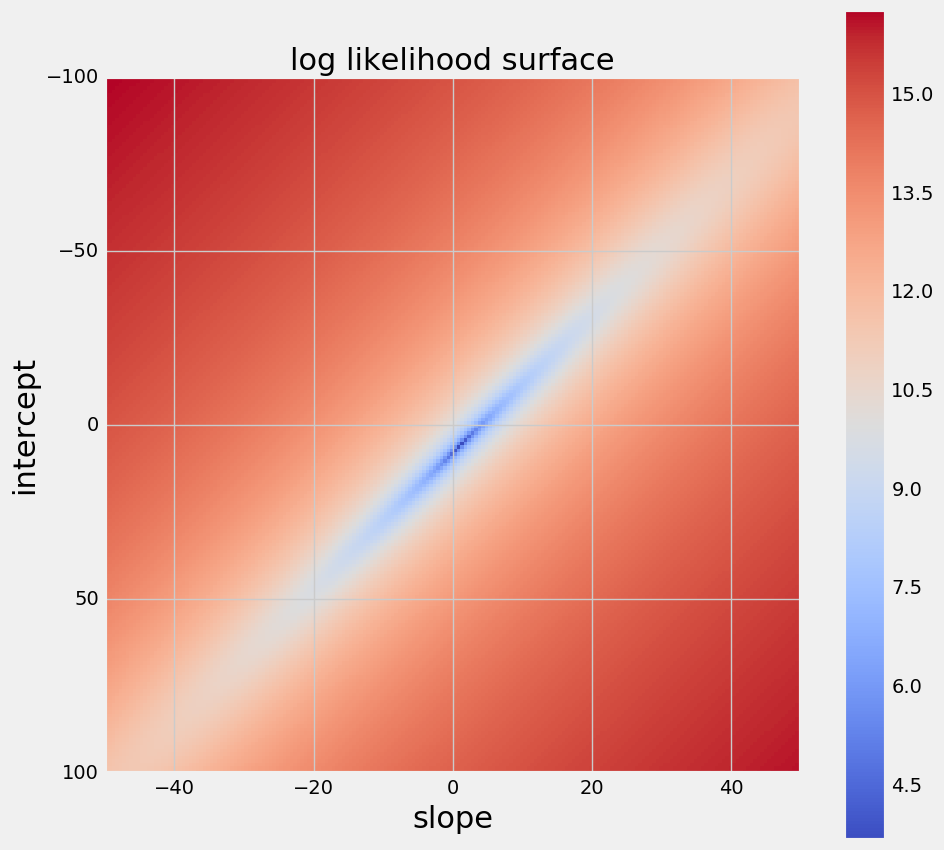

In [61]:
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), interpolation='nearest',extent = [-50,50,100,-100], cmap=cm.coolwarm,aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

In [62]:
data_cut = bblnrgdata[["AssessLand","AssessTot","BldgArea","ResArea","RetailArea"]]

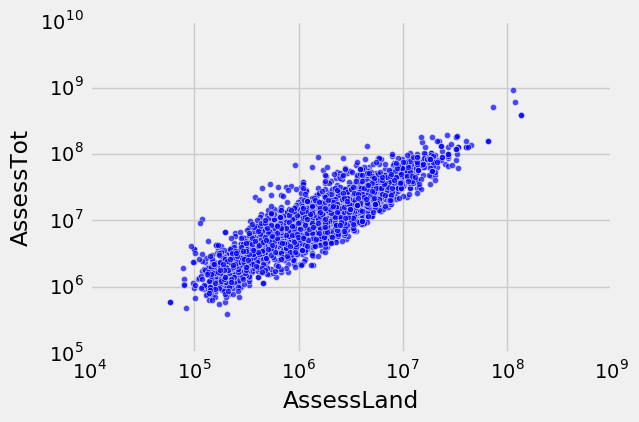

In [64]:
data_cut.plot.scatter(x="AssessLand", y="AssessTot", alpha=0.7, loglog=True)

## AssessTot VS AssessLand

There is a log-linear relationship between AssessTot and AssessLand